In [1]:
import numpy as np
import sys
import pandas as pd

from sklearn.metrics import mean_absolute_error

from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

import scipy

/home/wxk/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
train =pd.read_csv('../data/intern_data.csv').iloc[:,1:]
test = pd.read_csv('../data/intern_test.csv').iloc[:,1:]
num = train.shape[0]

tr_te = pd.concat((train, test), axis = 0)
tr_te_num = pd.get_dummies(tr_te)

In [3]:

tr_te_num  = tr_te_num.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
xtrain,xtest = np.split(tr_te_num.loc[:, tr_te_num.columns != 'y'], [num], axis=0)
xtrain = xtrain.values
xtest = xtest.values
y = train.loc[:,'y']


In [4]:
## neural net
def create_model(num_input):
    model = Sequential()
    
    model.add(Dense(num_input, input_dim = xtrain.shape[1], init = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
        
    model.add(Dense(220)) 
    model.add(PReLU())
    model.add(BatchNormalization())    
    model.add(Dropout(0.3))
    
    model.add(Dense(60))
    model.add(PReLU())
    model.add(BatchNormalization())    
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    model.compile(loss = 'mae', optimizer = 'adam')
    return(model)


In [5]:
nfolds = 5
folds = KFold(len(y), n_folds = nfolds, shuffle = True, random_state = 2018)


In [6]:
#early stopping is not helpful, manually tweaking is 
callbacks = [
    EarlyStopping(monitor='val_loss', patience = 30, verbose=0)
]

In [7]:
i = 1
epochs = 260
preds_test = np.zeros(xtest.shape[0])

preds = np.zeros(xtrain.shape[0])
for (inTr, inTe) in folds:
    xtr = xtrain[inTr]
    ytr = y[inTr]
    xte = xtrain[inTe] # xte is xde in fact
    yte = y[inTe]
    pred = np.zeros(xte.shape[0])
    model = create_model(xtr.shape[1])
 
    fit = model.fit(xtr ,ytr,verbose = 0,epochs= epochs, batch_size=32,shuffle= True)
    pred = model.predict(xte)
    score = mean_absolute_error(yte, pred)
    preds[inTe] = pred
    print('Fold ', i, '- MAE:', score)
    i += 1
    
    #predict on the testing set
    preds_test += model.predict(xtest)[:,0]
    
# average and save the predictions on testing set 
preds_test /= nfolds 
test["prediction"] = preds_test
test.to_csv("../output/submission_ANN.csv",index=False)



/home/wxk/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, input_dim=12, kernel_initializer="he_normal")`
  """
/home/wxk/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


Fold  1 - MAE: 0.11388632739
Fold  2 - MAE: 0.109613764618
Fold  3 - MAE: 0.0907788301974
Fold  4 - MAE: 0.110360291859
Fold  5 - MAE: 0.102450333028


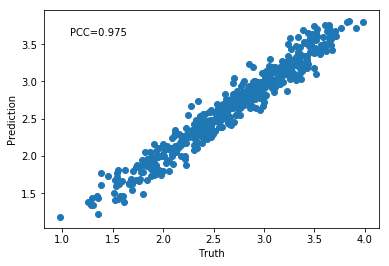

In [8]:

plt.scatter(y,preds)

scipy.stats.pearsonr(y,preds)

plt.xlabel('Truth')
plt.ylabel('Prediction')

PCC = round(scipy.stats.pearsonr(y,preds)[0],3)

plt.text(np.min(y)*1.1, 0.95*np.max(preds), r'PCC='+str(PCC),
         fontsize=10)